<a href="https://colab.research.google.com/github/ProAym/CarFuelConsumption/blob/main/Makine_%C3%B6%C4%9Frenemi_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
                                     Input, concatenate, BatchNormalization)
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Paths ---
csv_path = "/content/FuelConsumptionCo2_with_URLs.csv"  # CSV file path
image_base_path = "/content/images"          # Path to images folder

# --- Load Data ---
data = pd.read_csv(csv_path)
data = data.head(200)  # Use the first 200 rows

def load_images(data, image_folder, num_images=1):
    images = []
    valid_indices = []

    for idx, row in data.iterrows():
        # Format folder name: MAKE_MODEL with underscore between MAKE and MODEL
        folder_name = f"{row['MAKE']}_{row['MODEL']}".replace(' ', '').replace('/', '_')
        folder_path = os.path.join(image_folder, folder_name.upper())  # Ensure case matches

        if os.path.exists(folder_path):
            image_files = sorted(os.listdir(folder_path))[:num_images]  # Pick N images
            for img_file in image_files:
                image_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(image_path).resize((224, 224)).convert('RGB')
                    img_array = img_to_array(img) / 255.0  # Normalize
                    images.append(img_array)
                    valid_indices.append(idx)  # Keep the row index
                except Exception as e:
                    print(f"Error loading image: {image_path}, {e}")
        else:
            print(f"Folder not found: {folder_path}")
    return np.array(images), valid_indices


# Load images and filter valid rows
images, valid_indices = load_images(data, image_base_path)
data = data.iloc[valid_indices]  # Keep rows corresponding to loaded images

# --- Prepare Metadata ---
metadata = data[['ENGINESIZE', 'CYLINDERS', 'FUELTYPE']]
metadata = pd.get_dummies(metadata, columns=['FUELTYPE'])  # One-hot encode 'FUELTYPE'
metadata = metadata.to_numpy().astype(np.float32)

# Target Variable
target = data['FUELCONSUMPTION_COMB'].values.astype(np.float32)

# --- Split Data ---
X_images_train, X_images_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    images, metadata, target, test_size=0.2, random_state=42
)

# --- CNN Model ---
input_img = Input(shape=(224, 224, 3), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)

input_meta = Input(shape=(metadata.shape[1],), name="metadata_input")
meta_dense = Dense(64, activation='relu')(input_meta)
meta_dense = Dropout(0.5)(meta_dense)

combined = concatenate([x, meta_dense])
fc = Dense(128, activation='relu')(combined)
fc = Dropout(0.5)(fc)
output = Dense(1, activation='linear')(fc)

# Build and compile the model
model = Model(inputs=[input_img, input_meta], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# --- Train the Model ---
history = model.fit(
    [X_images_train, X_meta_train], y_train,
    validation_data=([X_images_test, X_meta_test], y_test),
    epochs=3,
    batch_size=16
)

# --- Save the Model ---
model.save("fuel_consumption_cnn_model.h5")

# --- Evaluate the Model ---
loss, mae = model.evaluate([X_images_test, X_meta_test], y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# --- Plot Training History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Mean Absolute Error Over Epochs")
plt.legend()
plt.show()


In [ ]:
import shutil
from google.colab import files

# 'images' klasörünü zip'e dönüştür
shutil.make_archive('images', 'zip', '/content/MERCEDES_BENZ_GL_350_BLUETEC_4MATIC')

# ZIP dosyasını indir
files.download('images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re

def format_folder_name(make, model):
    # Combine 'MAKE' and 'MODEL', remove spaces, special characters, and convert to uppercase
    combined_name = f"{make}_{model}".replace(' ', '_')
    combined_name = re.sub(r'[^A-Za-z0-9_]', '', combined_name)  # Remove non-alphanumeric
    return combined_name.upper()


In [ ]:
# Remove any existing ChromeDriver and Chrome
!rm -f /usr/bin/chromedriver
!rm -f /usr/bin/google-chrome

# Install the latest stable version of Google Chrome
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install -y

# Install the matching ChromeDriver version for Chrome 131
!wget https://storage.googleapis.com/chrome-for-testing-public/131.0.6778.139/linux64/chromedriver-linux64.zip
!unzip chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/bin/chromedriver


In [ ]:
!chromedriver --version
!google-chrome --version


ChromeDriver 131.0.6778.139 (c35bbcbd7c2775a12a3f320e05ac0022939b1a8a-refs/branch-heads/6778@{#2771})
Google Chrome 131.0.6778.139 


In [ ]:
# Set up ChromeDriver path
service = Service('/usr/bin/chromedriver')
driver = webdriver.Chrome(service=service, options=chrome_options)


Code that processes the csv table only original one


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Linear Regression ---
MAE: 0.0000
MSE: 0.0000
R^2: 1.0000


--- Linear Regression ---
Accuracy: 0.9486
Precision: 0.9605
Recall: 0.9486
F1 Score: 0.9505


--- Decision Tree ---
MAE: 0.0164
MSE: 0.0160
R^2: 0.9987


--- Decision Tree ---
Accuracy: 0.9766
Precision: 0.9793
Recall: 0.9766
F1 Score: 0.9755


--- Random Forest ---
MAE: 0.0121
MSE: 0.0018
R^2: 0.9999


--- Random Forest ---
Accuracy: 0.9766
Precision: 0.9803
Recall: 0.9766
F1 Score: 0.9761


--- Support Vector Machine ---
MAE: 0.1086
MSE: 0.1546
R^2: 0.9876


--- Support Vector Machine ---
Accuracy: 0.9065
Precision: 0.9089
Recall: 0.9065
F1 Score: 0.9015


--- Deep Neural Network ---
MAE: 0.1104
MSE: 0.0186
R^2: 0.9985


--- Deep Neural Network ---
Accuracy: 0.8879
Precision: 0.8959
Recall: 0.8879
F1 Score: 0.8879




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


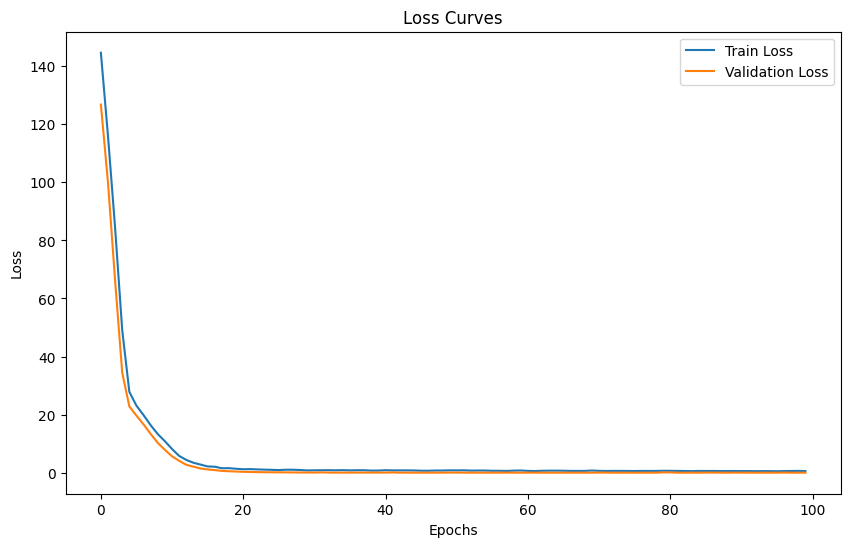

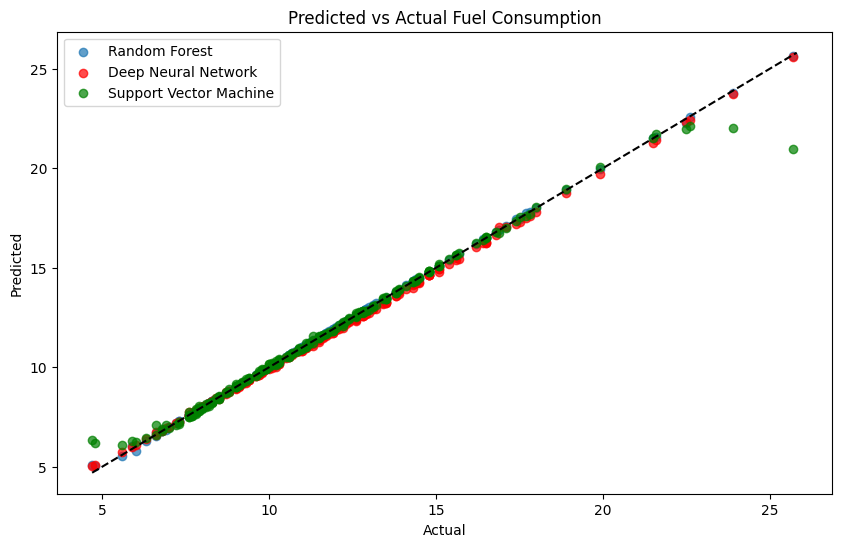

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


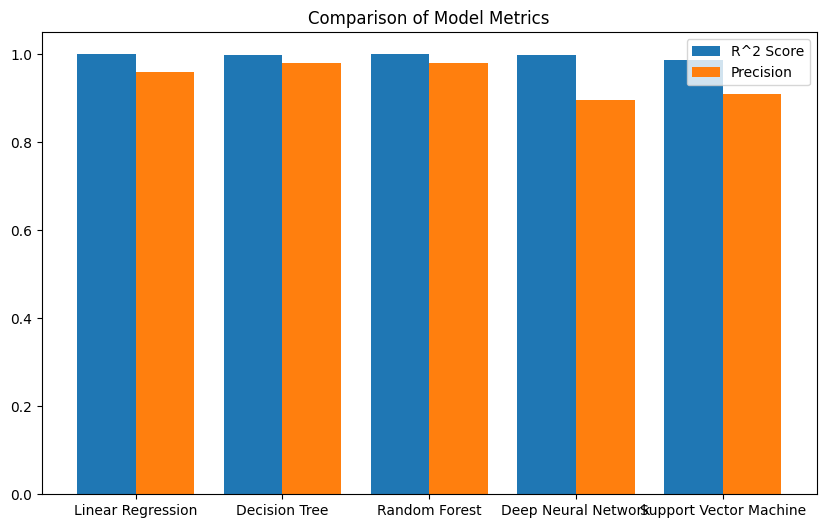

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/FuelConsumptionCo2.csv')

# Select features and target
features = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB']
target = 'FUELCONSUMPTION_COMB'

X = data[features]
y = data[target]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Traditional AI Models --- #

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
dt_preds = dt.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

# --- SVM Model --- #
# Support Vector Machine (SVR)
svm = SVR(kernel='rbf')  # You can try different kernels: 'linear', 'poly', 'sigmoid'
svm.fit(X_train_scaled, y_train)
svm_preds = svm.predict(X_test_scaled)

# --- Deep Learning Model --- #

# Build the model
dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
dnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = dnn.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

# Predict
dnn_preds = dnn.predict(X_test_scaled).flatten()

# --- Metrics Functions --- #

# Classification Metrics function (only works if rounded to nearest integer for classification metrics)
def classification_metrics(y_true, y_pred, model_name):
    y_true_rounded = np.rint(y_true)
    y_pred_rounded = np.rint(y_pred)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true_rounded, y_pred_rounded):.4f}")
    print(f"Precision: {precision_score(y_true_rounded, y_pred_rounded, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true_rounded, y_pred_rounded, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true_rounded, y_pred_rounded, average='weighted'):.4f}")
    print("\n")

# Regression Metrics function
def regression_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R^2: {r2_score(y_true, y_pred):.4f}")
    print("\n")

# Evaluate Traditional Models (Regression and Classification Metrics)
regression_metrics(y_test, lr_preds, "Linear Regression")
classification_metrics(y_test, lr_preds, "Linear Regression")

regression_metrics(y_test, dt_preds, "Decision Tree")
classification_metrics(y_test, dt_preds, "Decision Tree")

regression_metrics(y_test, rf_preds, "Random Forest")
classification_metrics(y_test, rf_preds, "Random Forest")

# Evaluate SVM Model (Regression and Classification Metrics)
regression_metrics(y_test, svm_preds, "Support Vector Machine")
classification_metrics(y_test, svm_preds, "Support Vector Machine")

# Evaluate Deep Learning Model (Regression and Classification Metrics)
regression_metrics(y_test, dnn_preds, "Deep Neural Network")
classification_metrics(y_test, dnn_preds, "Deep Neural Network")

# --- Visualization --- #

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction Comparison
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_preds, label='Random Forest', alpha=0.7)
plt.scatter(y_test, dnn_preds, label='Deep Neural Network', alpha=0.7, color='red')
plt.scatter(y_test, svm_preds, label='Support Vector Machine', alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='black')
plt.title('Predicted vs Actual Fuel Consumption')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# Bar chart of Metrics
models = ["Linear Regression", "Decision Tree", "Random Forest", "Deep Neural Network", "Support Vector Machine"]
metrics = [
    [r2_score(y_test, lr_preds), precision_score(np.rint(y_test), np.rint(lr_preds), average='weighted')],
    [r2_score(y_test, dt_preds), precision_score(np.rint(y_test), np.rint(dt_preds), average='weighted')],
    [r2_score(y_test, rf_preds), precision_score(np.rint(y_test), np.rint(rf_preds), average='weighted')],
    [r2_score(y_test, dnn_preds), precision_score(np.rint(y_test), np.rint(dnn_preds), average='weighted')],
    [r2_score(y_test, svm_preds), precision_score(np.rint(y_test), np.rint(svm_preds), average='weighted')],
]
metrics = np.array(metrics)

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
plt.bar(x - 0.2, metrics[:, 0], width=0.4, label='R^2 Score')
plt.bar(x + 0.2, metrics[:, 1], width=0.4, label='Precision')
plt.xticks(x, models)
plt.title('Comparison of Model Metrics')
plt.legend()
plt.show()


downloading the pictures from google


In [ ]:
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from PIL import Image
from io import BytesIO

# Chrome ayarları (Headless mod)
chrome_options = Options()
chrome_options.add_argument("--headless")  # Arka planda çalışır
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# ChromeDriver kurulum yolu
service = Service('/usr/bin/chromedriver')
driver = webdriver.Chrome(service=service, options=chrome_options)

# Resimlerin kaydedileceği klasör
output_dir = 'MERCEDES_BENZ_GL_350_BLUETEC_4MATIC'  # Klasör adı
os.makedirs(output_dir, exist_ok=True)

# Resim indirme fonksiyonu
def download_image(url, save_path):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image = image.convert('RGB')  # Resmi RGB formatına çevir
        image.save(save_path)
        print(f"İndirildi: {save_path}")
    except Exception as e:
        print(f"İndirilemedi {url}: {e}")

# Google Görseller'den resimleri sırayla indir
def scrape_images_from_google(search_url, num_images=120):
    driver.get(search_url)
    time.sleep(3)

    # Daha fazla resim yüklemek için sayfayı kaydır
    scroll_pause_time = 2
    while True:
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
        time.sleep(scroll_pause_time)

        # Sayfadaki tüm resimleri bul
        images = driver.find_elements(By.CSS_SELECTOR, 'img')
        if len(images) >= num_images:
            break

    # Resim URL'lerini topla
    image_urls = []
    for img in images:
        src = img.get_attribute('src')
        if src and src.startswith('http'):  # Geçerli bir URL olup olmadığını kontrol et
            image_urls.append(src)
        if len(image_urls) >= num_images:
            break

    # Resimleri indir
    for i, img_url in enumerate(image_urls):
        save_path = os.path.join(output_dir, f"{i+1}.jpg")
        download_image(img_url, save_path)

# Honda Accord için URL
search_url = "https://www.google.com/search?q=mercedes+benz+GL+350+BLUETEC+4MATIC+suv+standart+2014&sca_esv=35aa2c76c27153e3&udm=2&biw=1920&bih=951&sxsrf=ADLYWIJAQ1hjs5YNUfDvXAZl4ObtD7jBTA%3A1734519147244&ei=a6liZ_nADtiSxc8P3--BUA&ved=0ahUKEwi5ooKtk7GKAxVYSfEDHd93AAoQ4dUDCBE&uact=5&oq=mercedes+benz+GL+350+BLUETEC+4MATIC+suv+standart+2014&gs_lp=EgNpbWciNW1lcmNlZGVzIGJlbnogR0wgMzUwIEJMVUVURUMgNE1BVElDIHN1diBzdGFuZGFydCAyMDE0SItxUPoFWNlvcAF4AJABAJgBkgGgAeENqgEEMC4xNrgBA8gBAPgBAfgBApgCA6AC1ALCAgYQABgHGB7CAggQABgHGAgYHsICBBAAGB7CAgYQABgIGB6YAwCIBgGSBwMwLjOgB54P&sclient=img"

# Honda Accord resimlerini indir
print("MERCEDEC GL 350 BLUETEC 4MATIC resimleri indiriliyor...")
scrape_images_from_google(search_url, num_images=100)

# Tarayıcıyı kapat
driver.quit()
print("Resim indirme işlemi tamamlandı!")


image data processing


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import re  # Import regular expression module
from tensorflow.keras.models import load_model

# Path to image dataset
image_folder = '/path/to/your/image_dataset'  # Update with your folder path

# Function to load images and use folder names as labels
def load_images_and_labels_from_folders(image_folder, img_size=(128, 128)):
    images = []
    labels = []

    # Loop through folders in the image directory
    for folder in os.listdir(image_folder):
        folder_path = os.path.join(image_folder, folder)
        if os.path.isdir(folder_path):  # Check if it's a folder
            print(f"Processing folder: {folder}")  # Debugging folder names

            # Loop through image files in each folder
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):  # Check valid image formats
                    img_path = os.path.join(folder_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)  # Resize image
                        img = img / 255.0  # Normalize pixel values
                        images.append(img)
                        labels.append(folder)  # Use folder name as label

    print(f"Loaded {len(images)} images across {len(set(labels))} classes.")  # Debugging
    return np.array(images), np.array(labels)

# Load images and labels
img_size = (128, 128)
X_images, y_labels = load_images_and_labels_from_folders(image_folder, img_size)

# Encode labels (folder names) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_images, y_encoded, test_size=0.2, random_state=42)

# Build CNN model for classification
num_classes = len(np.unique(y_encoded))  # Number of unique labels
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Classification output
])

# Compile the model
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on test data
y_pred_probs = cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Save the model
cnn.save('car_model_classifier.h5')

# --- Visualization --- #
# Loss and Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display some predictions
print("Predicted vs Actual Labels:")
for i in range(10):  # Display 10 examples
    print(f"Predicted: {label_encoder.inverse_transform([y_pred[i]])[0]} | Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")

# Function to predict a single image
def predict_image(model_path, label_encoder, img_path, img_size=(128, 128)):
    model = load_model(model_path)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)  # Resize
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        prediction = model.predict(img)
        predicted_label = np.argmax(prediction, axis=1)
        class_name = label_encoder.inverse_transform(predicted_label)[0]
        print(f"Predicted Class: {class_name}")
    else:
        print("Error: Unable to load image. Please check the file path.")

# Ask user for an image path
img_path = input("Enter the path to the image you want to predict: ")
predict_image('car_model_classifier.h5', label_encoder, img_path)

print("CNN Image Processing Complete.")


Processing brand: VOLKSWAGEN
Processing model: VOLKSWAGEN_BEETLE
Processing model: VOLKSWAGEN_PASSAT
Processing model: VOLKSWAGEN_TIGUAN
Processing brand: AUDI
Processing model: AUDI_A4
Processing model: AUDI_A5_CABRIOLET_QUATTRO
Processing model: AUDI_A4_QUATTRO
Processing brand: FORD
Processing model: FORD_E150_VAN_FFV
Processing model: FORD_EDGE_AWD
Processing model: FORD_ C_MAX_HYBRID
Processing brand: FIAT
Processing model: FIAT_LINEA
Processing model: FIAT_EGEA
Processing model: FIAT_500_ABARTH_CABRIO
Processing brand: BMW
Processing model: BMW_X5
Processing model: BMW_320i
Processing model: BMW_320i CABRIOLET
Processing brand: MERCEDES
Processing model: MERCEDES-BENZ_C250
Processing model: MERCEDES-BENZ_B250
Processing model: MERCEDES- BENZ _GL_350_BLUETEC_4MATIC
Processing brand: HONDA
Processing model: HONDA_FIT
Processing model: HONDA_CIVIC
Processing model: HONDA_ACCORD
Processing brand: NISSAN
Processing model: NISSAN_FRONTIER 
Processing model: NISSAN_370Z_ROADSTER
Process

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 666s 9s/step - accuracy: 0.0438 - loss: 3.5184 - val_accuracy: 0.0640 - val_loss: 3.3516 - learning_rate: 0.0010
Epoch 2/7
75/75 ━━━━━━━━━━━━━━━━━━━━ 654s 9s/step - accuracy: 0.0448 - loss: 3.3664 - val_accuracy: 0.0875 - val_loss: 3.3114 - learning_rate: 0.0010
Epoch 3/7
 7/75 ━━━━━━━━━━━━━━━━━━━━ 8:08 7s/step - accuracy: 0.0467 - loss: 3.3393

KeyboardInterrupt: 

Yüklenen Görüntüler: 3378
Yüklenen Hedefler: 3378


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 1.2329 - mae: 0.8650 - val_loss: 1.0545 - val_mae: 0.7966
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.9803 - mae: 0.7666 - val_loss: 1.0057 - val_mae: 0.7732
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 0.8803 - mae: 0.7303 - val_loss: 0.9719 - val_mae: 0.7508
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - loss: 0.8353 - mae: 0.7080 - val_loss: 0.9271 - val_mae: 0.7310
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.7469 - mae: 0.6672 - val_loss: 0.9912 - val_mae: 0.7559
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - loss: 0.6320 - mae: 0.6290 - val_loss: 0.8651 - val_mae: 0.7041
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.5813 - mae: 0.5892 - val_loss: 0.8208 - val_mae: 0.6803
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - loss: 0.4753 - mae: 0.5398 - val_loss: 0.8259 - val_mae: 0.6861
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - loss: 0.4324 

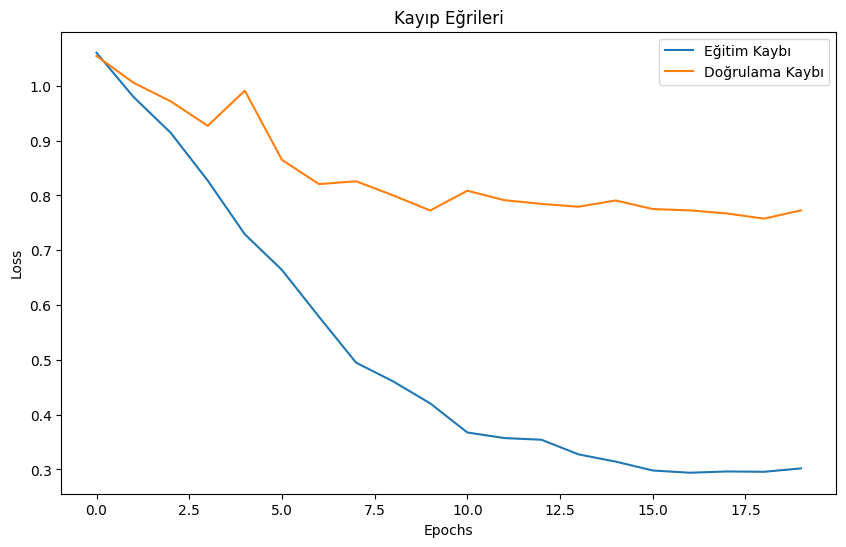

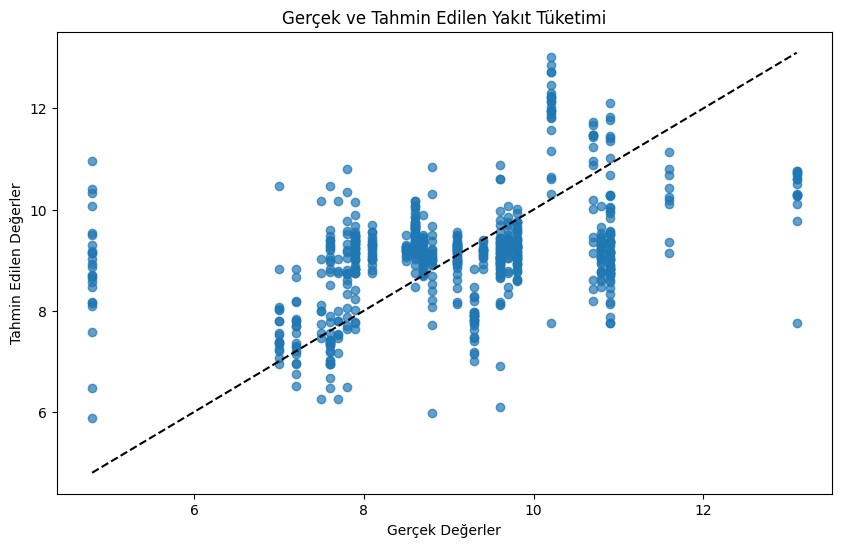

Error: The image at path_to_your_image.jpg does not exist.
Regresyon modeli tamamlandı.


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dosya yolları
image_folder = '/content/drive/MyDrive/araba'  # Görüntülerin bulunduğu klasör
csv_file = "/content/drive/MyDrive/FuelConsumptionCo2.csv"  # CSV dosyasının yolu

# CSV dosyasını yükle
df = pd.read_csv(csv_file)

# Model isimlerini normalize et
df['CLEANED_MODEL'] = (
    df['MODEL']
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace(r'[^A-Z0-9_]', '', regex=True)
)

# Gerekli sütunları seç
df = df[['MAKE', 'CLEANED_MODEL', 'FUELCONSUMPTION_COMB']]

# Görüntüleri ve yakıt tüketim verilerini yükleyen fonksiyon
def load_images_and_targets(image_folder, labels_df, img_size=(128, 128)):
    images = []
    targets = []

    # Görüntü klasörlerindeki tüm model isimlerini al
    available_models = [
        model_folder.upper().replace(' ', '_')
        for model_folder in os.listdir(image_folder)
        if os.path.isdir(os.path.join(image_folder, model_folder))
    ]

    # CSV dosyasında yalnızca bu modellere ait satırları filtrele
    filtered_df = labels_df[labels_df['CLEANED_MODEL'].str.upper().isin(available_models)]

    # Görüntüleri ve hedef değerleri yükle
    for index, row in filtered_df.iterrows():
        model = row['CLEANED_MODEL']
        fuel_consumption = row['FUELCONSUMPTION_COMB']

        model_path = os.path.join(image_folder, model)  # Model klasörünün yolu
        if os.path.isdir(model_path):
            for file in os.listdir(model_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(model_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img / 255.0  # Normalize et
                        images.append(img)
                        targets.append(fuel_consumption)

    print(f"Yüklenen Görüntüler: {len(images)}")
    print(f"Yüklenen Hedefler: {len(targets)}")
    return np.array(images), np.array(targets)


# Görüntüleri ve hedefleri yükle
img_size = (128, 128)
X_images, y_targets = load_images_and_targets(image_folder, df, img_size)

# Eğitim ve test setine ayır
if len(X_images) > 0 and len(y_targets) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_images, y_targets, test_size=0.2, random_state=42)

    # Hedef değişkeni ölçekle
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Regresyon modeli kodu burada devam eder
else:
    print("Görüntü veya hedef yüklenemedi, lütfen dosya yapısını kontrol edin!")

# CNN modelini oluştur
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Regresyon çıktısı
])

# Modeli derle
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Modeli eğitme
history = cnn.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

# Modeli değerlendirme
loss, mae = cnn.evaluate(X_test, y_test_scaled)
print(f"Test MAE: {mae:.4f}")

# Tahminler
y_pred_scaled = cnn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# --- Model Evaluation (R² Score) --- #
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2:.4f}")

# --- Additional Evaluation Metrics --- #
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

# --- Visualization --- #
# Eğitim ve doğrulama kaybı
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Eğrileri')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gerçek ve tahmin edilen değerler
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.title('Gerçek ve Tahmin Edilen Yakıt Tüketimi')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.show()

# --- Predicting for a New Image --- #
def predict_fuel_consumption(model, image_path, img_size=(128, 128), scaler=None):
    # Load and preprocess the image
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Predict the fuel consumption
            predicted_scaled = model.predict(img)
            predicted = scaler.inverse_transform(predicted_scaled).flatten()
            return predicted
        else:
            print("Error: Image could not be loaded.")
            return None
    else:
        print(f"Error: The image at {image_path} does not exist.")
        return None

# Test on a new image
image_path = "path_to_your_image.jpg"  # Path to a test image
predicted_fuel_consumption = predict_fuel_consumption(cnn, image_path, scaler=scaler)
if predicted_fuel_consumption is not None:
    print(f"Predicted Fuel Consumption: {predicted_fuel_consumption[0]:.2f} L/100km")

print("Regresyon modeli tamamlandı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Yüklenen Görüntüler: 5309
Yüklenen Hedefler: 5309


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 1.2034 - mae: 0.6976 - val_loss: 1.0292 - val_mae: 0.6309
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - loss: 0.9957 - mae: 0.6549 - val_loss: 1.0120 - val_mae: 0.6355
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.7706 - mae: 0.5985 - val_loss: 0.6646 - val_mae: 0.5368
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - loss: 0.5358 - mae: 0.5259 - val_loss: 0.5729 - val_mae: 0.5345
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - loss: 0.4348 - mae: 0.4711 - val_loss: 0.5114 - val_mae: 0.4833
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.3370 - mae: 0.4126 - val_loss: 0.4584 - val_mae: 0.4731
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.3333 - mae: 0.4179 - val_loss: 0.4747 - val_mae: 0.4756
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.3160 - mae: 0.3949 - val_loss: 0.4529 - val_mae: 0.4662
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/

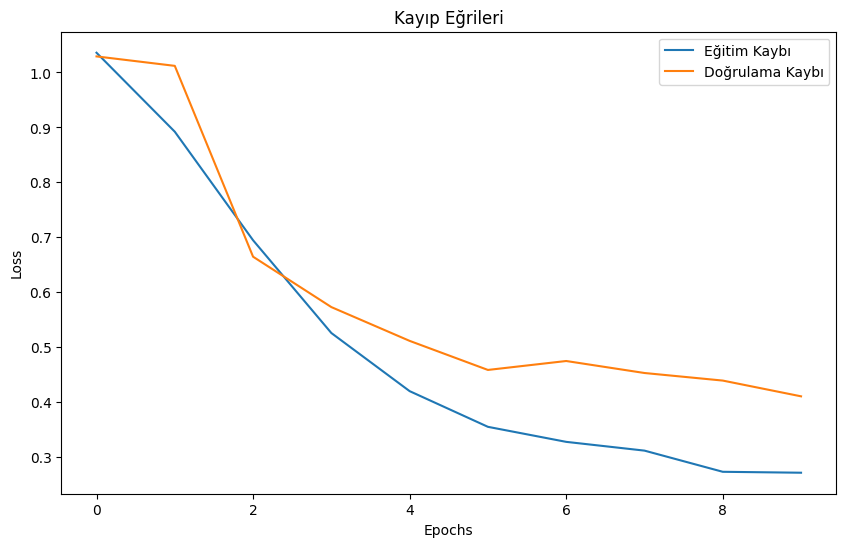

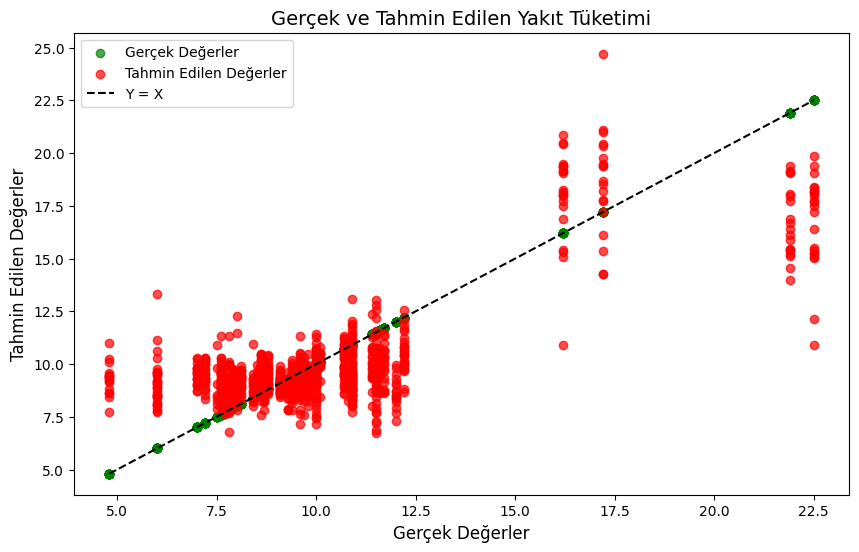

Regresyon modeli tamamlandı.
Enter the path to the image for prediction (1/5) (Type 'exit' to quit): /content/drive/MyDrive/volvo.jpeg


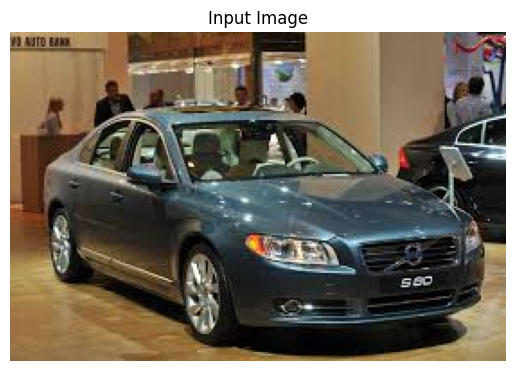

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Fuel Consumption: 9.71 L/100km
Enter the path to the image for prediction (2/5) (Type 'exit' to quit): /content/drive/MyDrive/volvo1.jpeg


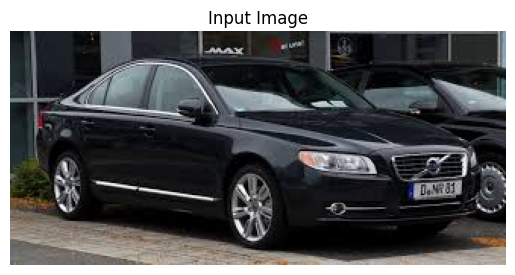

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Fuel Consumption: 9.73 L/100km
Enter the path to the image for prediction (3/5) (Type 'exit' to quit): /content/drive/MyDrive/subaru.jpeg


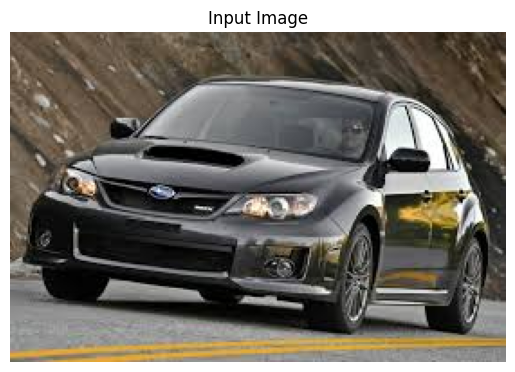

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Fuel Consumption: 9.45 L/100km


KeyboardInterrupt: Interrupted by user

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Dosya yolları
image_folder = '/content/drive/MyDrive/araba'  # Görüntülerin bulunduğu klasör
csv_file = '/content/FuelConsumptionCo2 (2).csv'   # CSV dosyasının yolu

# CSV dosyasını yükle
df = pd.read_csv(csv_file)

# Model isimlerini normalize et
df['CLEANED_MODEL'] = (
    df['MODEL']
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace(r'[^A-Z0-9_]', '', regex=True)
)

# Gerekli sütunları seç
df = df[['MAKE', 'CLEANED_MODEL', 'FUELCONSUMPTION_COMB']]

# Görüntüleri ve yakıt tüketim verilerini yükleyen fonksiyon
def load_images_and_targets(image_folder, labels_df, img_size=(128, 128)):
    images = []
    targets = []

    # Görüntü klasörlerindeki tüm model isimlerini al
    available_models = [
        model_folder.upper().replace(' ', '_')
        for model_folder in os.listdir(image_folder)
        if os.path.isdir(os.path.join(image_folder, model_folder))
    ]

    # CSV dosyasında yalnızca bu modellere ait satırları filtrele
    filtered_df = labels_df[labels_df['CLEANED_MODEL'].str.upper().isin(available_models)]

    # Görüntüleri ve hedef değerleri yükle
    for index, row in filtered_df.iterrows():
        model = row['CLEANED_MODEL']
        fuel_consumption = row['FUELCONSUMPTION_COMB']

        model_path = os.path.join(image_folder, model)  # Model klasörünün yolu
        if os.path.isdir(model_path):
            for file in os.listdir(model_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(model_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img / 255.0  # Normalize et
                        images.append(img)
                        targets.append(fuel_consumption)

    print(f"Yüklenen Görüntüler: {len(images)}")
    print(f"Yüklenen Hedefler: {len(targets)}")
    return np.array(images), np.array(targets)

# Görüntüleri ve hedefleri yükle
img_size = (128, 128)
X_images, y_targets = load_images_and_targets(image_folder, df, img_size)

# Eğitim ve test setine ayır
if len(X_images) > 0 and len(y_targets) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_images, y_targets, test_size=0.2, random_state=42)

    # Hedef değişkeni ölçekle
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Regresyon için CNN modeli oluştur
    cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Regresyon çıktısı
    ])

    # Modeli derleme
    cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Modeli eğitme
    history = cnn.fit(
        X_train, y_train_scaled,
        validation_split=0.2,
        epochs=10,
        batch_size=32
    )

    # Modeli değerlendirme
    loss, mae = cnn.evaluate(X_test, y_test_scaled)
    print(f"Test MAE: {mae:.4f}")

    # Tahminler
    y_pred_scaled = cnn.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Gerçek değerler
    y_test_original = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Performans metriklerini hesapla
    mse = mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2: {r2:.4f}")

    # --- Visualization --- #
    # Eğitim ve doğrulama kaybı
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp Eğrileri')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Gerçek ve tahmin edilen değerler
plt.figure(figsize=(10, 6))

# Gerçek değerlerin scatter plot'u
plt.scatter(y_test_original, y_test_original, alpha=0.7, color='green', label='Gerçek Değerler')

# Tahmin edilen değerlerin scatter plot'u
plt.scatter(y_test_original, y_pred, alpha=0.7, color='red', label='Tahmin Edilen Değerler')

# Y = X doğrusu
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         '--', color='black', label='Y = X')

# Başlık ve etiketler
plt.title('Gerçek ve Tahmin Edilen Yakıt Tüketimi', fontsize=14)
plt.xlabel('Gerçek Değerler', fontsize=12)
plt.ylabel('Tahmin Edilen Değerler', fontsize=12)

# Legend (açıklama) ekle
plt.legend()

# Grafik göster
plt.show()

print("Regresyon modeli tamamlandı.")


def predict_fuel_consumption():
    global cnn, scaler  # Use global variables for model and scaler
    max_attempts = 5  # Maximum number of attempts
    attempts = 0

    while attempts < max_attempts:
        try:
            image_path = input(f"Enter the path to the image for prediction ({attempts + 1}/{max_attempts}) (Type 'exit' to quit): ")
            if image_path.lower() == 'exit':
                print("Prediction process terminated.")
                break

            img = cv2.imread(image_path)
            if img is not None:
                # Display the image
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper color rendering
                plt.imshow(img_rgb)
                plt.title("Input Image")
                plt.axis("off")
                plt.show()

                # Resize, normalize, and prepare for prediction
                img = cv2.resize(img, img_size)  # Resize
                img = img / 255.0  # Normalize
                img = np.expand_dims(img, axis=0)  # Add batch dimension

                # Make prediction
                pred_scaled = cnn.predict(img)
                pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]

                print(f"Predicted Fuel Consumption: {pred:.2f} L/100km")
            else:
                print("Image could not be loaded. Please check the file path.")

            attempts += 1  # Increment attempt count
        except ValueError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

    print("Maximum prediction attempts reached. Prediction process terminated.")


predict_fuel_consumption()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Yüklenen Görüntüler: 5309
Yüklenen Hedefler: 5309
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


266/266 ━━━━━━━━━━━━━━━━━━━━ 96s 338ms/step - loss: 1.0142 - mae: 0.7148 - val_loss: 0.3883 - val_mae: 0.4552
Epoch 2/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 137s 316ms/step - loss: 0.4061 - mae: 0.4490 - val_loss: 0.3413 - val_mae: 0.4268
Epoch 3/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 316ms/step - loss: 0.3584 - mae: 0.4341 - val_loss: 0.3341 - val_mae: 0.4178
Epoch 4/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 93s 348ms/step - loss: 0.3617 - mae: 0.4329 - val_loss: 0.3102 - val_mae: 0.4102
Epoch 5/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 140s 339ms/step - loss: 0.3347 - mae: 0.4165 - val_loss: 0.3044 - val_mae: 0.4063
Epoch 6/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 92s 343ms/step - loss: 0.3259 - mae: 0.4150 - val_loss: 0.3515 - val_mae: 0.4169
Epoch 7/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 137s 321ms/step - loss: 0.3125 - mae: 0.3999 - val_loss: 0.2967 - val_mae: 0.4038
Epoch 8/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 90s 335ms/step - loss: 0.3215 - mae: 0.4067 - val_loss: 0.2939 - val_mae: 0.4028
Epoch 9/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 

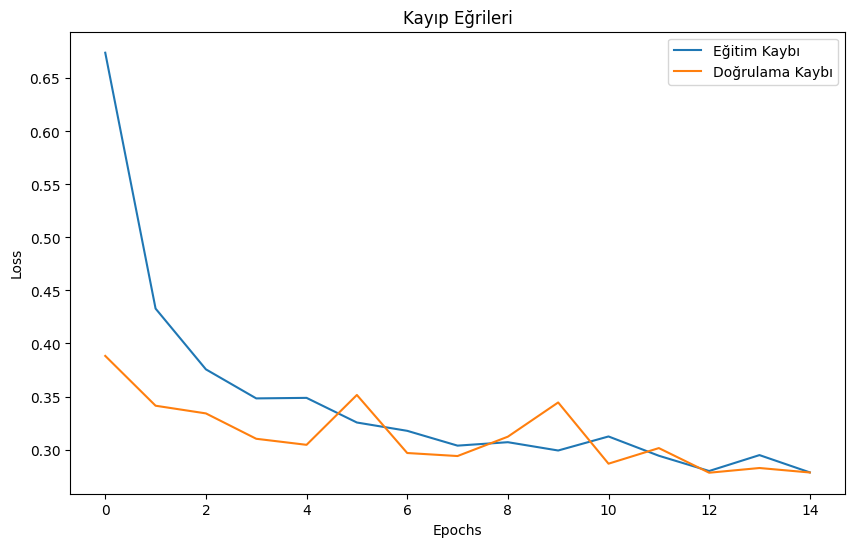

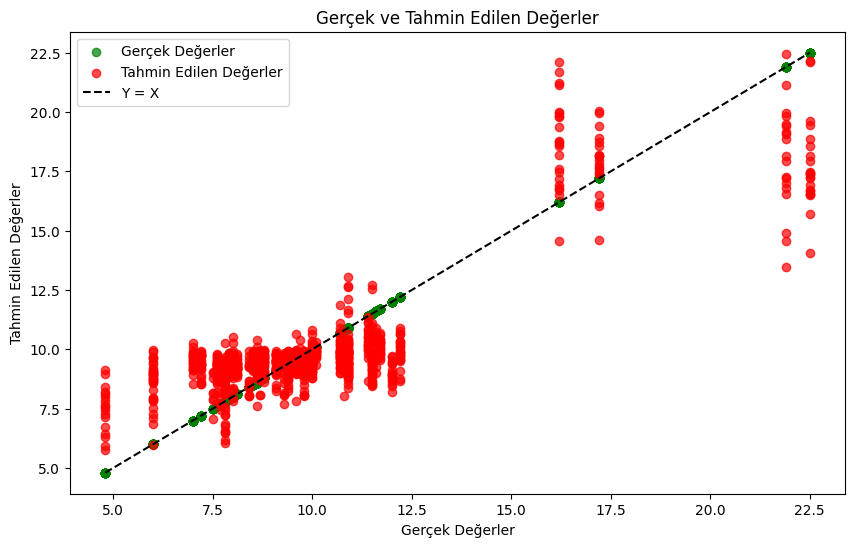

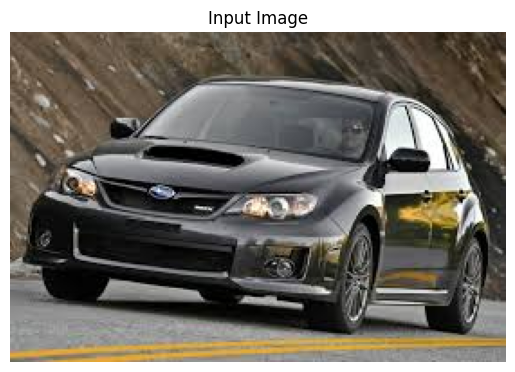

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Fuel Consumption: 9.65 L/100km


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Dosya yolları
image_folder = '/content/drive/MyDrive/araba'  # Görüntülerin bulunduğu klasör
csv_file = '/content/FuelConsumptionCo2 (2).csv'  # CSV dosyasının yolu

# CSV dosyasını yükle
df = pd.read_csv(csv_file)

# Model isimlerini normalize et
df['CLEANED_MODEL'] = (
    df['MODEL']
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace(r'[^A-Z0-9_]', '', regex=True)
)

# Gerekli sütunları seç
df = df[['MAKE', 'CLEANED_MODEL', 'FUELCONSUMPTION_COMB']]

# Görüntüleri ve yakıt tüketim verilerini yükleyen fonksiyon
def load_images_and_targets(image_folder, labels_df, img_size=(128, 128)):
    images = []
    targets = []

    available_models = [
        model_folder.upper().replace(' ', '_')
        for model_folder in os.listdir(image_folder)
        if os.path.isdir(os.path.join(image_folder, model_folder))
    ]

    filtered_df = labels_df[labels_df['CLEANED_MODEL'].str.upper().isin(available_models)]

    for index, row in filtered_df.iterrows():
        model = row['CLEANED_MODEL']
        fuel_consumption = row['FUELCONSUMPTION_COMB']

        model_path = os.path.join(image_folder, model)
        if os.path.isdir(model_path):
            for file in os.listdir(model_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(model_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img / 255.0
                        images.append(img)
                        targets.append(fuel_consumption)

    print(f"Yüklenen Görüntüler: {len(images)}")
    print(f"Yüklenen Hedefler: {len(targets)}")
    return np.array(images), np.array(targets)

# Görüntüleri ve hedefleri yükle
img_size = (128, 128)
X_images, y_targets = load_images_and_targets(image_folder, df, img_size)

# Eğitim ve test setine ayır
if len(X_images) > 0 and len(y_targets) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_images, y_targets, test_size=0.2, random_state=42)

    # Hedef değişkeni ölçekle
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Veri arttırma için ImageDataGenerator
    data_gen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, zoom_range=0.1)

    # Eğitim verilerine veri arttırmayı uygulayın
    train_gen = data_gen.flow(X_train, y_train_scaled, batch_size=16)

    # MobileNetV2 tabanlı model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

    # Transfer Learning: MobileNetV2 katmanlarını dondur
    for layer in base_model.layers:
        layer.trainable = False

    # MobileNetV2 üzerine regresyon için yeni katmanlar ekle
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')  # Regresyon için
    ])

    # Modeli derleme
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

    # Modeli eğitme
    history = model.fit(
        train_gen,
        validation_data=(X_test, y_test_scaled),
        epochs=15
    )

    # Modeli değerlendirme
    loss, mae = model.evaluate(X_test, y_test_scaled)
    print(f"Test MAE: {mae:.4f}")

    # Tahminler
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Gerçek değerler
    y_test_original = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Performans metriklerini hesapla
    mse = mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2: {r2:.4f}")

    # --- Visualization --- #
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp Eğrileri')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Gerçek ve tahmin edilen değerler
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_test_original, alpha=0.7, color='green', label='Gerçek Değerler')
    plt.scatter(y_test_original, y_pred, alpha=0.7, color='red', label='Tahmin Edilen Değerler')

    plt.plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()],
             '--', color='black', label='Y = X')
    plt.title("Gerçek ve Tahmin Edilen Değerler")
    plt.xlabel("Gerçek Değerler")
    plt.ylabel("Tahmin Edilen Değerler")
    plt.legend()
    plt.show()

    # Yakıt tüketimini tahmin eden fonksiyon
    def predict_fuel_consumption():
        max_attempts = 5
        attempts = 0

        while attempts < max_attempts:
            try:
                image_path = input(f"Enter the path to the image for prediction ({attempts + 1}/{max_attempts}) (Type 'exit' to quit): ")
                if image_path.lower() == 'exit':
                    print("Prediction process terminated.")
                    break

                img = cv2.imread(image_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_rgb)
                    plt.title("Input Image")
                    plt.axis("off")
                    plt.show()

                    img = cv2.resize(img, img_size)
                    img = img / 255.0
                    img = np.expand_dims(img, axis=0)

                    pred_scaled = model.predict(img)
                    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
                    print(f"Predicted Fuel Consumption: {pred:.2f} L/100km")
                else:
                    print("Image could not be loaded. Please check the file path.")
                attempts += 1
            except Exception as e:
                print(f"Error: {e}")

    # Call prediction function
    predict_fuel_consumption()
else:
    print("Görüntü veya hedef yüklenemedi, lütfen dosya yapısını kontrol edin!")


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Dosya yolları
image_folder = '/content/drive/MyDrive/CAR_PROJECT/araba'  # Görüntülerin bulunduğu klasör
csv_file = 'FuelConsumptionCo2 (2).csv'  # CSV dosyasının yolu

# CSV dosyasını yükle
df = pd.read_csv(csv_file)

# Model isimlerini normalize et
df['CLEANED_MODEL'] = (
    df['MODEL']
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace(r'[^A-Z0-9_]', '', regex=True)
)

# Gerekli sütunları seç
df = df[['MAKE', 'CLEANED_MODEL', 'FUELCONSUMPTION_COMB']]

# Görüntüleri ve yakıt tüketim verilerini yükleyen fonksiyon
def load_images_and_targets(image_folder, labels_df, img_size=(128, 128)):
    images = []
    targets = []

    # Görüntü klasörlerindeki tüm model isimlerini al
    available_models = [
        model_folder.upper().replace(' ', '_')
        for model_folder in os.listdir(image_folder)
        if os.path.isdir(os.path.join(image_folder, model_folder))
    ]

    # CSV dosyasında yalnızca bu modellere ait satırları filtrele
    filtered_df = labels_df[labels_df['CLEANED_MODEL'].str.upper().isin(available_models)]

    # Görüntüleri ve hedef değerleri yükle
    for index, row in filtered_df.iterrows():
        model = row['CLEANED_MODEL']
        fuel_consumption = row['FUELCONSUMPTION_COMB']

        model_path = os.path.join(image_folder, model)  # Model klasörünün yolu
        if os.path.isdir(model_path):
            for file in os.listdir(model_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(model_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = img / 255.0  # Normalize et
                        images.append(img)
                        targets.append(fuel_consumption)

    print(f"Yüklenen Görüntüler: {len(images)}")
    print(f"Yüklenen Hedefler: {len(targets)}")
    return np.array(images), np.array(targets)

# Görüntüleri ve hedefleri yükle
img_size = (128, 128)
X_images, y_targets = load_images_and_targets(image_folder, df, img_size)

# Eğitim ve test setine ayır
if len(X_images) > 0 and len(y_targets) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_images, y_targets, test_size=0.2, random_state=42)

    # Hedef değişkeni ölçekle
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

    # VGG16 tabanlı model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

    # Transfer Learning: VGG16 katmanlarını dondur
    for layer in base_model.layers:
        layer.trainable = False

    # VGG16 üzerine regresyon için yeni katmanlar ekle
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Regresyon çıktısı
    ])

    # Modeli derleme
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Modeli eğitme
    history = model.fit(
        X_train, y_train_scaled,
        validation_split=0.2,
        epochs=20,
        batch_size=32
    )

    # Modeli değerlendirme
    loss, mae = model.evaluate(X_test, y_test_scaled)
    print(f"Test MAE: {mae:.4f}")

    # Tahminler
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Gerçek değerler
    y_test_original = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    # Performans metriklerini hesapla
    mse = mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R^2: {r2:.4f}")

    # --- Visualization --- #
    # Eğitim ve doğrulama kaybı
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp Eğrileri')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Gerçek ve tahmin edilen değerler grafiği
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_pred, color='red', alpha=0.7, label='Tahmin Edilen Değerler')
    plt.scatter(y_test_original, y_test_original, color='green', alpha=0.7, label='Gerçek Değerler')
    plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--', color='black', label='Doğru Çizgisi')
    plt.title('Gerçek ve Tahmin Edilen Yakıt Tüketimi')
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')
    plt.legend()
    plt.show()

    # Yakıt tüketimini tahmin eden fonksiyon
    def predict_fuel_consumption():
        max_attempts = 5
        attempts = 0

        while attempts < max_attempts:
            try:
                image_path = input(f"Enter the path to the image for prediction ({attempts + 1}/{max_attempts}) (Type 'exit' to quit): ")
                if image_path.lower() == 'exit':
                    print("Prediction process terminated.")
                    break

                img = cv2.imread(image_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_rgb)
                    plt.title("Input Image")
                    plt.axis("off")
                    plt.show()

                    img = cv2.resize(img, img_size)
                    img = img / 255.0
                    img = np.expand_dims(img, axis=0)

                    pred_scaled = model.predict(img)
                    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
                    print(f"Predicted Fuel Consumption: {pred:.2f} L/100km")
                else:
                    print("Image could not be loaded. Please check the file path.")
                attempts += 1
            except Exception as e:
                print(f"Error: {e}")

    # Call prediction function
    predict_fuel_consumption()
else:
    print("Görüntü veya hedef yüklenemedi, lütfen dosya yapısını kontrol edin!")

KeyboardInterrupt: 